# **프로그래밍과제 01: Facial Landmark Dataset**

잘 알려진 얼굴 랜드마크 데이터셋의 하나인 Helen Dataset으로부터 Dataset 객체와 Dataloader를 정의하고 생성한다.


1. 먼저 데이터셋 [홈페이지](http://www.ifp.illinois.edu/~vuongle2/helen/)에서 데이터셋을 다운로드한다. 홈페이지의 `3.b`와 `3.c`에 링크된 모든 파일들을 다운로드한다. `3.a`의 파일들을 다운로드할 필요는 없다.

2. 4개의 `zip` 파일(`train_1.zip`, `train_2.zip`, `train_3.zip`, `train_4.zip`)로 나뉘어져있는 `train` 이미지들을 압축해제하여 모두 `helen/train` 이라는 이름의 디렉토리에 모아서 저장한다. 트레이닝 이미지는 총 2000장이다.

3. 테스크이미지 `test.zip`은 `helen/test`라는 이름의 디렉토리에 압축을 해제하여 저장한다. 테스트 이미지는 330장이다.

4. `annotation.zip` 파일은 압축을 해제하여 `helen/annotation` 이라는 이름의 디렉토리에 저장한다. `1.txt`에서 `2330.txt`까지 총 2330개의 텍스트파일이다. 이중 1번에서 2000번까지는 트레이닝 이미지에 대한 주석이고, 나머지는 테스트 이미지에 대한 주석이다.

5. `trainnames.txt`와 `testnames.txt` 파일은 `helen` 디렉토리에 저장한다.


In [4]:
import os
import torch
import pandas as pd;
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import random

**문제 1:** 커스텀 데이터셋 클래스 `HelenDataSet`을 작성하라. `__getitem__` 메서드는 이미지와 랜드마크의 딕셔너리를 반환하도록 구현하라. 아래의 코드 예와 같이 트레인 데이터셋과 테스트 데이터셋을 생성할 수 있어야 한다.

In [5]:
root_dir = "./helen"
landmarks_frame = pd.read_csv(root_dir + "/annotation/{}.txt".format("99"), delimiter=",", header=None, skiprows=1)
landmarks = landmarks_frame.iloc[:, :]
landmarks = np.asarray([landmarks])
landmarks = landmarks.astype('float').reshape(-1,2)

print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

landmarks_frame


Landmarks shape: (194, 2)
First 4 Landmarks: [[ 266.19 1651.25]
 [ 266.6  1714.23]
 [ 268.71 1779.74]
 [ 277.49 1845.06]]


,0,1
0,266.19,1651.25
1,266.60,1714.23
2,268.71,1779.74
3,277.49,1845.06
4,280.59,1911.02
...,...,...
189,504.98,1359.01
190,539.68,1372.46
191,574.36,1386.03
192,610.11,1397.12


In [19]:
class HelenDataSet(Dataset):
    def __init__(self, root_dir, partition, transform=None):
      self.partition = partition
      self.root_dir = root_dir
      self.transform = transform
      
      # train/test split
      if self.partition == 'train':
        with open(os.path.join(self.root_dir, 'trainnames.txt'), 'r') as f:
           self.names = f.read().splitlines()
      elif self.partition == 'test':
        with open(os.path.join(self.root_dir, 'testnames.txt'), 'r') as f:
           self.names = f.read().splitlines()

    def __len__(self):
      return len(self.names)
    
    def __getitem__(self, index):
      if torch.is_tensor(index):
        idx = idx.tolist()

      # 이미지 읽기
      img_dir = self.root_dir+"/{}/".format(self.partition)
      img_name = self.names[index-1]
      # print(img_name)
      image = np.array(Image.open(img_dir + img_name + ".jpg")) # PIL image를 numpy array로 변환

      # 랜드마크 읽기
      if(self.partition == "test"):
        index += 2000
      landmarks_frame = pd.read_csv(self.root_dir + "/annotation/{}.txt".format(index), delimiter=",", header=None, skiprows=1)
      # print(landmarks_frame)
      landmarks = landmarks_frame.iloc[:,:].values
      landmarks = np.asarray([landmarks])
      landmarks = landmarks.astype('float').reshape(-1,2)
      sample = {'image': image, 'landmarks': landmarks}

      if self.transform:
        sample = self.transform(sample)

      return sample

In [20]:
# 데이터 디렉토리는 이 노트북 파일과 동일한 디렉토리에 위치한다고 가정한다.
root_dir = './helen'
train_set = HelenDataSet(root_dir=root_dir, partition='train', transform=None)
test_set = HelenDataSet(root_dir=root_dir, partition='test', transform=None)

In [21]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.show()

118554337_1


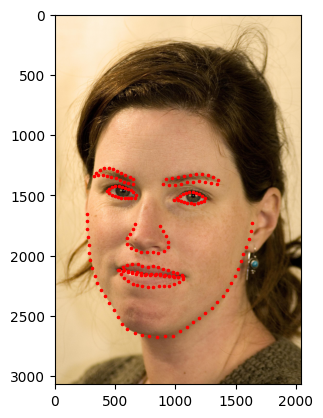

In [22]:
train_sample = train_set[99]
show_landmarks(train_sample['image'], train_sample['landmarks'])

3036934213_1


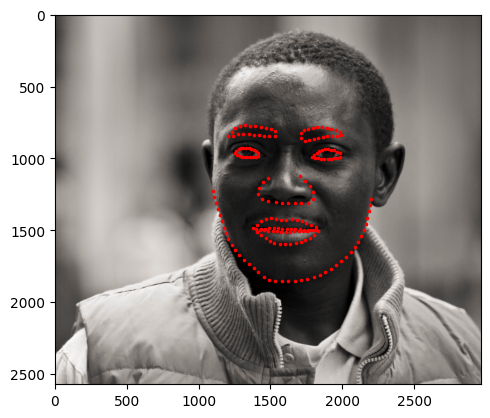

In [23]:
test_sample = test_set[89]
show_landmarks(test_sample['image'], test_sample['landmarks'])

**문제 2:** 이미지와 랜드마크 데이터의 전처리를 위한 세 개의 클래스 `MyReScale`, `MyRandomCrop`, 그리고 `MyRandomHorizontalFlip`을 작성하라. 세 클래스는 아래의 코드 예제와 같은 방식으로 사용할 수 있어야 한다. `MyRandomHorizontalFlip`은 1/2의 확률로 이미지를 수평적으로 플립한다.

In [27]:
class MyRescale(object):
    # YOUR CODE HERE
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        # print(image.shape[:2])
        new_h, new_w = self.output_size

        img = Image.fromarray(image)
        img = img.resize((new_h, new_w), resample=0)
        img = np.array(img)
        # img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


In [28]:
class MyRandomCrop(object):
    # YOUR CODE HERE
    def __init__(self, output_size): 
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

1115234911_1
(960, 1220)


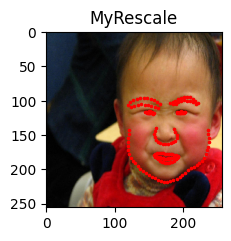

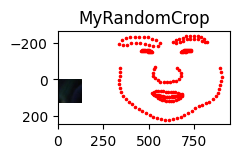

(960, 1220)


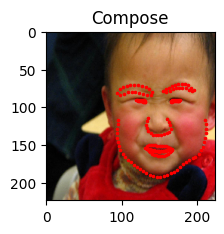

In [30]:
scale = MyRescale((256, 256))
crop = MyRandomCrop((128, 128))
composed = transforms.Compose([MyRescale((256, 256)),
                               MyRandomCrop((224, 224))])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_set[66]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [31]:
class MyRandomHorizontalFlip(object):
    # YOUR CODE HERE
    def __init__(self):
        pass

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # 1/2의 확률로 이미지를 수평적으로 플립합니다.
        if np.random.random() < 0.5:
            image = np.flip(image, axis=1)

            # 랜드마크 데이터를 플립합니다.
            landmarks[:, 0] = image.shape[1] - landmarks[:, 0]

        return {'image': image, 'landmarks': landmarks}

103887554_1
(2112, 2573)


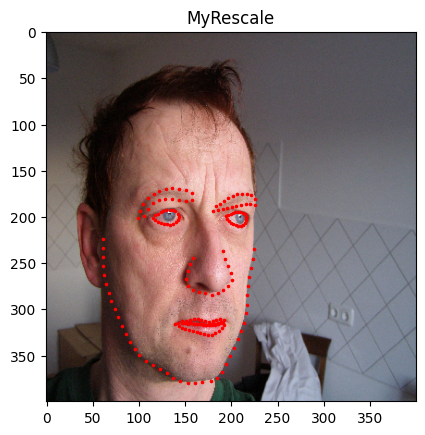

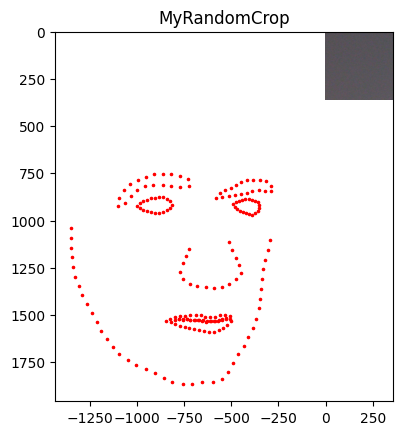

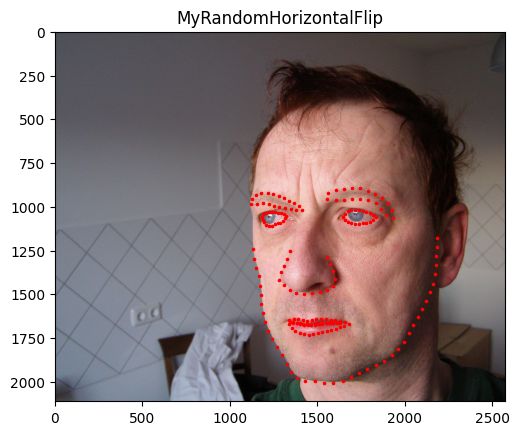

(2112, 2573)


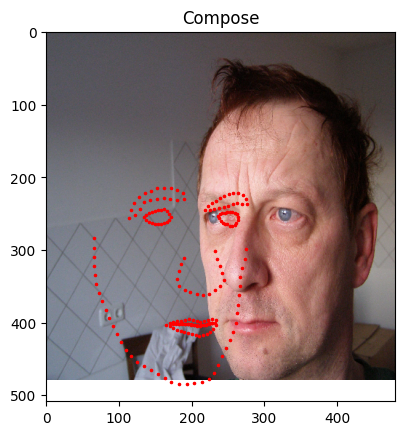

In [37]:
scale = MyRescale((400, 400))
crop = MyRandomCrop((360, 360))
flip = MyRandomHorizontalFlip()
composed = transforms.Compose([MyRescale((512, 512)),
                               MyRandomCrop((480, 480)),
                               MyRandomHorizontalFlip()])

# Apply each of the above transforms on sample.
sample = train_set[22]
for i, tsfrm in enumerate([scale, crop, flip, composed]):
    transformed_sample = tsfrm(sample)
    plt.title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

In [55]:
class MyToTensor(object):
    def __init__(self):
        self.img_tensorfier = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = image.copy()  # Add this line to create a copy of the image
        image = self.img_tensorfier(image)
        return {'image': image,
                'landmarks': torch.from_numpy(landmarks)}

**문제 3:** `MyRescale`, `MyRandomCrop`, `MyRandomHorizontalFlip`, 그리고 `MyToTensor` 변환이 적용된 트레인 데이터셋 객체 `transformed_train_dataset`을 생성하라. 이때 먼저 이미지를 `(524, 524)` 크기로 resize하고, 이어서 `(512, 512)` 크기로 랜덤 크롭하라. 그런 다음 랜덤 플립을 하고, 마지막에 `MyToTensor` 변환을 적용한다. 또한 `MyRescale`과 `MyToTensor` 변환만이 적용된 테스트 데이터셋 객체 `transformed_test_dataset`을 생성하라. 이미지는 `(512, 512)` 크기로 resize한다.

In [56]:
# YOUR CODE HERE
train_transforms = transforms.Compose([
    MyRescale((524, 524)),
    MyRandomCrop((512, 512)),
    MyRandomHorizontalFlip(),
    MyToTensor()
])

test_transforms = transforms.Compose([
    MyRescale((512, 512)),
    MyToTensor()
])

transformed_train_dataset = HelenDataSet(root_dir, partition="train", transform=train_transforms)
transformed_test_dataset = HelenDataSet(root_dir, partition="test", transform=test_transforms)

In [57]:
batch_size = 4
train_dataloader = DataLoader(transformed_train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

**문제 4:** 데이터로더로 부터 추출된 하나의 배치(batch)를 받아서 4장의 이미지와 landmark를 아래의 실행 예와 같이 디스플레이하는 함수 `show_batch`를 작성하라. 위에 있는 `show_landmarks` 함수를 호출해도 사용해도 무방하다.

In [60]:
def show_batch(sample_batch):
    # YOUR CODE HERE
    images_batch, landmarks_batch = sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    
    for i in range(batch_size):
        image = images_batch[i].numpy().transpose((1, 2, 0))
        image = (image * 0.5) + 0.5  # Unnormalize the image
        landmarks = landmarks_batch[i].numpy()
        plt.figure()
        show_landmarks(image, landmarks)


2620035751_8
(928, 928)
2667636661_4
(1223, 1249)
2544306273_1
(1627, 1957)
2099073485_1
(2592, 3456)
torch.Size([4, 3, 512, 512]) torch.Size([4, 194, 2])


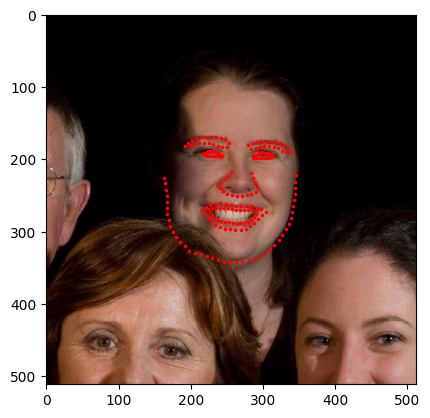

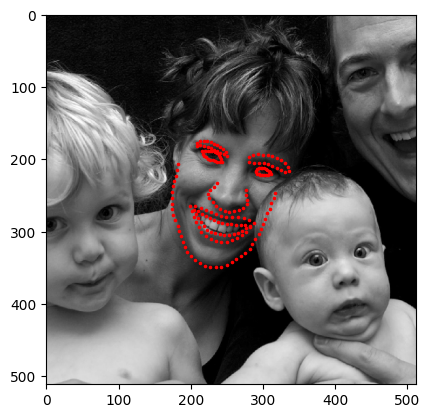

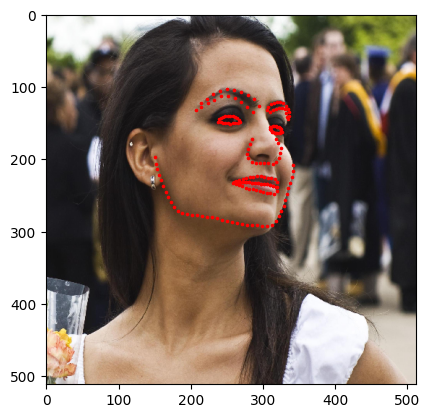

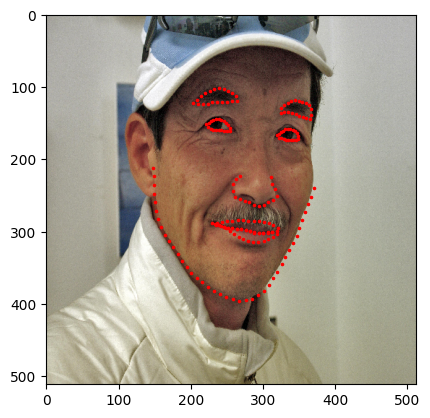

In [69]:
for sample_batch in train_dataloader:
    print(sample_batch['image'].size(), sample_batch['landmarks'].size())
    show_batch(sample_batch)
    break

3266693323_1
(2116, 2116)
296814969_3
(846, 846)
2968560214_1
(1024, 683)
2968784797_1
(2848, 4288)
torch.Size([4, 3, 512, 512]) torch.Size([4, 194, 2])


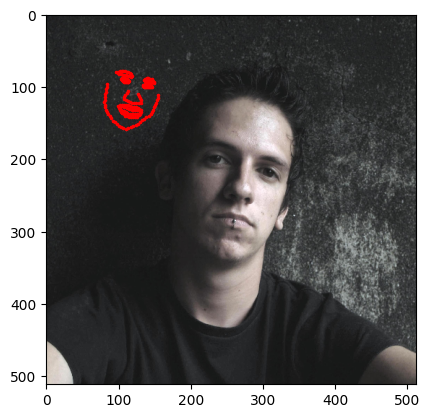

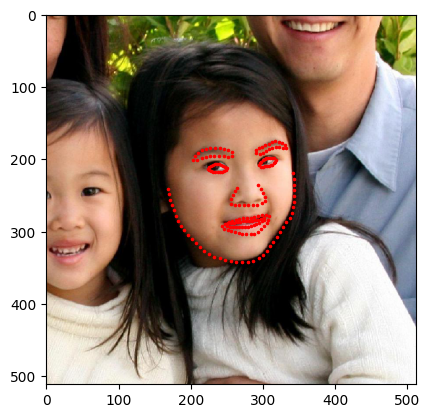

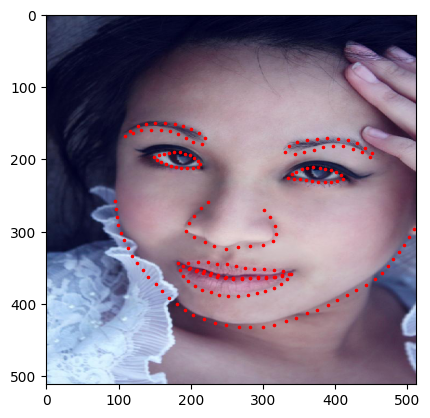

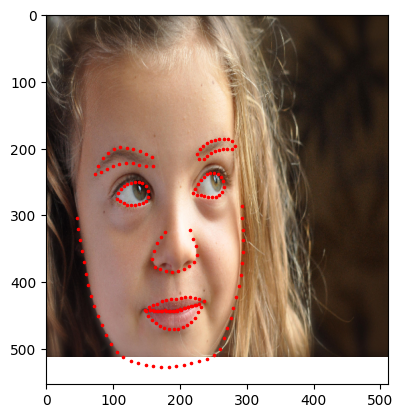

In [70]:
for sample_batch in test_dataloader:
    print(sample_batch['image'].size(), sample_batch['landmarks'].size())
    show_batch(sample_batch)
    break